In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Reshape, multiply
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.layers.core import Lambda
from keras.utils.vis_utils import plot_model
from tensorflow.python.framework import ops
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D

import keras.backend as K
from keras import optimizers
import random
import sys
import cv2
import os
from skimage import io
import tensorflow as tf
import numpy as np
from keras.models import load_model
from keras import initializers
from keras.callbacks import ModelCheckpoint, EarlyStopping

import csv
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

category_num=3
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 
config = tf.compat.v1.ConfigProto(log_device_placement=True,
inter_op_parallelism_threads=0,
intra_op_parallelism_threads=0,
allow_soft_placement=True)
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config = config)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:b3:00.0, compute capability: 6.1



Number of images in train set :  2993
Number of images in test set :  643
Number of images in val set :  642


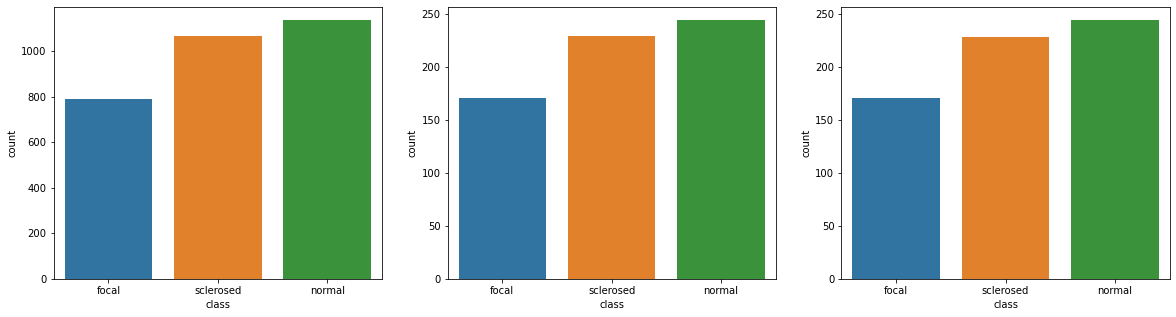

In [2]:
root_path = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/'
train_pred_test_folders = os.listdir(root_path)

train_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/train/' #one more seg_train folder within
test_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/test/'
val_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/val/'
quantity_tr = {} 
quantity_te = {}
quantity_va = {}
for folder in os.listdir(train_folders):
    quantity_tr[folder] = len(os.listdir(train_folders+folder))

for folder in os.listdir(test_folders):
    quantity_te[folder] = len(os.listdir(test_folders+folder))

for folder in os.listdir(val_folders):
    quantity_va[folder] = len(os.listdir(val_folders+folder))

quantity_train = pd.DataFrame(list(quantity_tr.items()), index=range(0,len(quantity_tr)), columns=['class','count'])
quantity_test = pd.DataFrame(list(quantity_te.items()), index=range(0,len(quantity_te)), columns=['class','count'])
quantity_val = pd.DataFrame(list(quantity_va.items()), index=range(0,len(quantity_va)), columns=['class','count'])

figure, ax = plt.subplots(1,3,figsize=(20,5))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])
sns.barplot(x='class',y='count',data=quantity_val,ax=ax[2])
#sns.barplot(x='class',y='count',data=quantity_new_data,ax=ax[3])

print("Number of images in train set : ", sum(quantity_tr.values()))
print("Number of images in test set : ",sum(quantity_te.values()))
#number_of_images_in_prediction_set = len(os.listdir(seg_pred_folders))
print("Number of images in val set : ",sum(quantity_va.values()))
#print("Number of images in new dataset : ",sum(quantity_ne.values()))

plt.show()

In [3]:
IMG_SIZE = 150

In [4]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
validation_datagen = ImageDataGenerator(preprocessing_function= preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function= preprocess_input)

In [5]:
def train(BATCH_SIZE):
    train_generator = train_datagen.flow_from_directory(train_folders,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical',
                                                        target_size=(IMG_SIZE, IMG_SIZE))
    return train_generator

In [6]:
def validation(BATCH_SIZE):
    
    validation_generator = validation_datagen.flow_from_directory(val_folders, 
                                                                  batch_size=BATCH_SIZE, 
                                                                  class_mode='categorical', 
                                                                  target_size=(IMG_SIZE, IMG_SIZE))
    return validation_generator

In [7]:
def test(BATCH_SIZE):
    test_generator = test_datagen.flow_from_directory(test_folders,
                                                      batch_size=BATCH_SIZE,
                                                      class_mode='categorical',
                                                      target_size=(IMG_SIZE, IMG_SIZE))
    return test_generator

In [8]:
def show_few_images(number_of_examples, predict_using_model):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(train_folders)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(train_folders)):
        image_ids = os.listdir(os.path.join(train_folders,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:
            path = os.path.join(train_folders,folder,image_ids[j])
            display = cv2.resize(cv2.imread(path),(IMG_SIZE,IMG_SIZE))
            display = display/IMG_SIZE
            
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True:'+folder
            if(predict_using_model):
                predicted_classname = inv_map_classes[np.argmax(predict_using_model.predict(np.array([display])))]
                title = title+'\nPredict :'+predicted_classname
            ax1[axs].set_title(title)
            axs=axs+1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


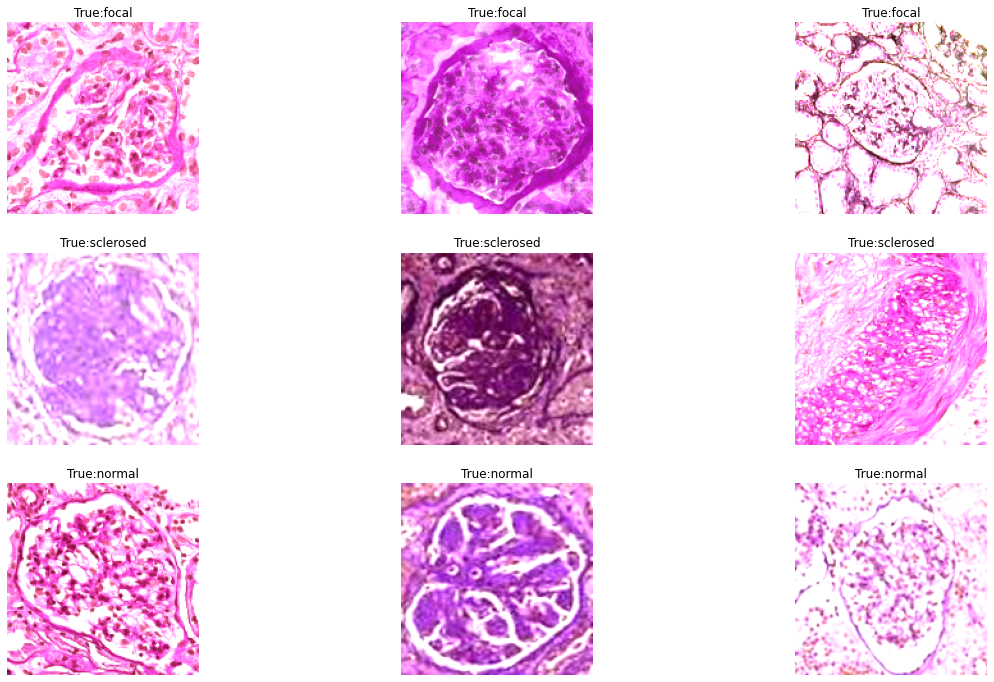

In [9]:
show_few_images(3,None)

In [10]:
with tf.device("/gpu:1"):
    model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
    for layers in model.layers:
        layers.trainable=False
    last_output = model.layers[-1].output
    output = Flatten()(last_output)
    output = Dense(128, activation = 'relu')(output)
    output = Dense(3, activation = 'softmax')(output)
    model = Model(model.input, output)
    model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])

In [11]:
data_train = train(1)
data_validation = validation(1)
model.fit(
    data_train,
#    steps_per_epoch=2000,
    epochs=30,
    validation_data=data_validation,
    workers=10,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
2993/2993 [==============================] - 84s 23ms/step - loss: 3.5073 - acc: 0.6252 - val_loss: 0.5897 - val_acc: 0.7601
Epoch 2/30
2993/2993 [==============================] - 69s 23ms/step - loss: 0.6002 - acc: 0.7606 - val_loss: 0.4173 - val_acc: 0.8146
Epoch 3/30
2993/2993 [==============================] - 69s 23ms/step - loss: 0.5121 - acc: 0.7755 - val_loss: 0.4094 - val_acc: 0.8318
Epoch 4/30
2993/2993 [==============================] - 69s 23ms/step - loss: 0.5058 - acc: 0.8042 - val_loss: 0.4297 - val_acc: 0.8287
Epoch 5/30
2993/2993 [==============================] - 70s 23ms/step - loss: 0.4708 - acc: 0.7962 - val_loss: 0.3982 - val_acc: 0.8084
Epoch 6/30
2993/2993 [==============================] - 71s 24ms/step - loss: 0.4685 - acc: 0.8077 - val_loss: 0.3854 - val_acc: 0.8380
Epoch 7/30
2993/2993 [==============================] - 70s 24ms/step - loss: 0.4321 - acc: 0.8202 - 

In [12]:
data_test = test(1)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
643/643 [==============================] - 11s 17ms/step - loss: 0.8381 - acc: 0.8243


[0.8380612134933472, 0.8242612481117249]

In [13]:
data_train = train(2)
data_validation = validation(2)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
1497/1497 [==============================] - 62s 33ms/step - loss: 0.3064 - acc: 0.8670 - val_loss: 0.6203 - val_acc: 0.8598
Epoch 2/30
1497/1497 [==============================] - 50s 33ms/step - loss: 0.2921 - acc: 0.8720 - val_loss: 0.8654 - val_acc: 0.8536
Epoch 3/30
1497/1497 [==============================] - 50s 33ms/step - loss: 0.2885 - acc: 0.8727 - val_loss: 0.5817 - val_acc: 0.8660
Epoch 4/30
1497/1497 [==============================] - 51s 34ms/step - loss: 0.2845 - acc: 0.8730 - val_loss: 0.4757 - val_acc: 0.8660
Epoch 5/30
1497/1497 [==============================] - 50s 33ms/step - loss: 0.2652 - acc: 0.8744 - val_loss: 0.4714 - val_acc: 0.8754
Epoch 6/30
1497/1497 [==============================] - 50s 33ms/step - loss: 0.2963 - acc: 0.8780 - val_loss: 0.7526 - val_acc: 0.8645
Epoch 7/30
1497/1497 [==============================] - 50s 33ms/step - loss: 0.3091 - acc: 0.8757 - 

In [14]:
data_test = test(2)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
322/322 [==============================] - 8s 24ms/step - loss: 0.4569 - acc: 0.8538


[0.4569054841995239, 0.8538102507591248]

In [15]:
data_train = train(4)
data_validation = validation(4)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
749/749 [==============================] - 59s 61ms/step - loss: 0.2618 - acc: 0.8968 - val_loss: 0.6826 - val_acc: 0.8707
Epoch 2/30
749/749 [==============================] - 45s 59ms/step - loss: 0.2508 - acc: 0.9021 - val_loss: 0.7589 - val_acc: 0.8536
Epoch 3/30
749/749 [==============================] - 45s 60ms/step - loss: 0.2230 - acc: 0.9081 - val_loss: 0.8965 - val_acc: 0.8738
Epoch 4/30
749/749 [==============================] - 45s 60ms/step - loss: 0.2308 - acc: 0.9091 - val_loss: 0.6508 - val_acc: 0.8629
Epoch 5/30
749/749 [==============================] - 45s 60ms/step - loss: 0.2272 - acc: 0.8981 - val_loss: 0.7615 - val_acc: 0.8692
Epoch 6/30
749/749 [==============================] - 45s 60ms/step - loss: 0.2153 - acc: 0.9054 - val_loss: 0.7417 - val_acc: 0.8676
Epoch 7/30
749/749 [==============================] - 45s 60ms/step - loss: 0.2201 - acc: 0.8961 - val_loss: 0.68

In [16]:
data_test = test(4)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
161/161 [==============================] - 20s 124ms/step - loss: 0.5669 - acc: 0.8694


[0.566900908946991, 0.8693623542785645]

In [17]:
data_train = train(8)
data_validation = validation(8)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
375/375 [==============================] - 57s 109ms/step - loss: 0.2046 - acc: 0.9235 - val_loss: 0.6330 - val_acc: 0.8816
Epoch 2/30
375/375 [==============================] - 41s 108ms/step - loss: 0.1858 - acc: 0.9265 - val_loss: 0.6083 - val_acc: 0.8754
Epoch 3/30
375/375 [==============================] - 42s 108ms/step - loss: 0.1902 - acc: 0.9262 - val_loss: 0.6657 - val_acc: 0.8832
Epoch 4/30
375/375 [==============================] - 42s 111ms/step - loss: 0.2126 - acc: 0.9232 - val_loss: 0.7429 - val_acc: 0.8801
Epoch 5/30
375/375 [==============================] - 43s 112ms/step - loss: 0.1956 - acc: 0.9248 - val_loss: 0.6416 - val_acc: 0.8738
Epoch 6/30
375/375 [==============================] - 43s 111ms/step - loss: 0.2130 - acc: 0.9302 - val_loss: 0.6994 - val_acc: 0.8738
Epoch 7/30
375/375 [==============================] - 42s 112ms/step - loss: 0.1856 - acc: 0.9255 - val_los

In [18]:
data_test = test(8)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
81/81 [==============================] - 5s 65ms/step - loss: 0.7951 - acc: 0.8631


[0.7950676679611206, 0.8631415367126465]

In [11]:
data_train = train(16)
data_validation = validation(16)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
188/188 [==============================] - 38s 153ms/step - loss: 5.1432 - acc: 0.6105 - val_loss: 0.5570 - val_acc: 0.8100
Epoch 2/30
188/188 [==============================] - 7s 36ms/step - loss: 0.5421 - acc: 0.8037 - val_loss: 0.4000 - val_acc: 0.8427
Epoch 3/30
188/188 [==============================] - 7s 35ms/step - loss: 0.4694 - acc: 0.8179 - val_loss: 0.4134 - val_acc: 0.8411
Epoch 4/30
188/188 [==============================] - 8s 40ms/step - loss: 0.3445 - acc: 0.8649 - val_loss: 0.3593 - val_acc: 0.8785
Epoch 5/30
188/188 [==============================] - 12s 63ms/step - loss: 0.3180 - acc: 0.8619 - val_loss: 0.3298 - val_acc: 0.8754
Epoch 6/30
188/188 [==============================] - 9s 46ms/step - loss: 0.2925 - acc: 0.8837 - val_loss: 0.3082 - val_acc: 0.8863
Epoch 7/30
188/188 [==============================] - 21s 108ms/step - loss: 0.2610 - acc: 0.8931 - val_loss: 0.3440

In [12]:
data_test = test(16)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
41/41 [==============================] - 9s 227ms/step - loss: 0.3301 - acc: 0.9114


[0.33008962869644165, 0.9113530516624451]

In [13]:
data_train = train(32)
data_validation = validation(32)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
94/94 [==============================] - 47s 382ms/step - loss: 0.1019 - acc: 0.9612 - val_loss: 0.3870 - val_acc: 0.8988
Epoch 2/30
94/94 [==============================] - 27s 261ms/step - loss: 0.0791 - acc: 0.9696 - val_loss: 0.4485 - val_acc: 0.8925
Epoch 3/30
94/94 [==============================] - 32s 310ms/step - loss: 0.0800 - acc: 0.9676 - val_loss: 0.4055 - val_acc: 0.8925
Epoch 4/30
94/94 [==============================] - 33s 320ms/step - loss: 0.0693 - acc: 0.9763 - val_loss: 0.4262 - val_acc: 0.8910
Epoch 5/30
94/94 [==============================] - 30s 292ms/step - loss: 0.0778 - acc: 0.9773 - val_loss: 0.4208 - val_acc: 0.8894
Epoch 6/30
94/94 [==============================] - 29s 281ms/step - loss: 0.0701 - acc: 0.9729 - val_loss: 0.4703 - val_acc: 0.9034
Epoch 7/30
94/94 [==============================] - 32s 321ms/step - loss: 0.0779 - acc: 0.9736 - val_loss: 0.4003 - va

In [14]:
data_test = test(32)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
21/21 [==============================] - 4s 172ms/step - loss: 0.4154 - acc: 0.8927


[0.41543012857437134, 0.8926905393600464]

In [15]:
data_train = train(64)
data_validation = validation(64)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
47/47 [==============================] - 61s 925ms/step - loss: 0.0535 - acc: 0.9796 - val_loss: 0.4956 - val_acc: 0.8972
Epoch 2/30
47/47 [==============================] - 36s 657ms/step - loss: 0.0607 - acc: 0.9786 - val_loss: 0.5549 - val_acc: 0.8894
Epoch 3/30
47/47 [==============================] - 32s 584ms/step - loss: 0.0365 - acc: 0.9870 - val_loss: 0.5186 - val_acc: 0.8847
Epoch 4/30
47/47 [==============================] - 39s 690ms/step - loss: 0.0335 - acc: 0.9883 - val_loss: 0.5006 - val_acc: 0.9003
Epoch 5/30
47/47 [==============================] - 39s 684ms/step - loss: 0.0363 - acc: 0.9870 - val_loss: 0.5155 - val_acc: 0.8956
Epoch 6/30
47/47 [==============================] - 32s 570ms/step - loss: 0.0331 - acc: 0.9886 - val_loss: 0.4902 - val_acc: 0.9065
Epoch 7/30
47/47 [==============================] - 31s 524ms/step - loss: 0.0298 - acc: 0.9880 - val_loss: 0.5185 - va

In [16]:
data_test = test(64)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
11/11 [==============================] - 3s 295ms/step - loss: 0.3937 - acc: 0.9129


[0.39369437098503113, 0.9129082560539246]

In [17]:
data_train = train(128)
data_validation = validation(128)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
24/24 [==============================] - 55s 1s/step - loss: 0.0235 - acc: 0.9923 - val_loss: 0.6406 - val_acc: 0.8941
Epoch 2/30
24/24 [==============================] - 42s 2s/step - loss: 0.0239 - acc: 0.9923 - val_loss: 0.5966 - val_acc: 0.8956
Epoch 3/30
24/24 [==============================] - 49s 1s/step - loss: 0.0213 - acc: 0.9916 - val_loss: 0.6012 - val_acc: 0.8956
Epoch 4/30
24/24 [==============================] - 41s 1s/step - loss: 0.0275 - acc: 0.9886 - val_loss: 0.6122 - val_acc: 0.8956
Epoch 5/30
24/24 [==============================] - 47s 1s/step - loss: 0.0270 - acc: 0.9896 - val_loss: 0.5909 - val_acc: 0.9003
Epoch 6/30
24/24 [==============================] - 48s 1s/step - loss: 0.0237 - acc: 0.9906 - val_loss: 0.6229 - val_acc: 0.8988
Epoch 7/30
24/24 [==============================] - 42s 1s/step - loss: 0.0256 - acc: 0.9913 - val_loss: 0.5947 - val_acc: 0.8988
Epoch 8

In [18]:
data_test = test(128)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
6/6 [==============================] - 3s 483ms/step - loss: 0.4285 - acc: 0.9222


[0.4284740686416626, 0.9222394824028015]

In [19]:
data_train = train(256)
data_validation = validation(256)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
12/12 [==============================] - 69s 4s/step - loss: 0.0144 - acc: 0.9957 - val_loss: 0.6621 - val_acc: 0.8988
Epoch 2/30
12/12 [==============================] - 16s 921ms/step - loss: 0.0108 - acc: 0.9963 - val_loss: 0.6194 - val_acc: 0.9065
Epoch 3/30
12/12 [==============================] - 24s 964ms/step - loss: 0.0136 - acc: 0.9947 - val_loss: 0.6297 - val_acc: 0.9050
Epoch 4/30
12/12 [==============================] - 24s 956ms/step - loss: 0.0138 - acc: 0.9957 - val_loss: 0.6350 - val_acc: 0.8972
Epoch 5/30
12/12 [==============================] - 24s 988ms/step - loss: 0.0115 - acc: 0.9977 - val_loss: 0.6370 - val_acc: 0.9034
Epoch 6/30
12/12 [==============================] - 24s 985ms/step - loss: 0.0166 - acc: 0.9943 - val_loss: 0.6155 - val_acc: 0.9065
Epoch 7/30
12/12 [==============================] - 24s 1s/step - loss: 0.0166 - acc: 0.9947 - val_loss: 0.6498 - val_acc:

In [20]:
data_test = test(256)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
3/3 [==============================] - 15s 7s/step - loss: 0.4286 - acc: 0.9222


[0.4285906255245209, 0.9222394824028015]

In [21]:
data_train = train(512)
data_validation = validation(512)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
6/6 [==============================] - 48s 5s/step - loss: 0.0117 - acc: 0.9953 - val_loss: 0.6539 - val_acc: 0.9050
Epoch 2/30
6/6 [==============================] - 16s 2s/step - loss: 0.0114 - acc: 0.9967 - val_loss: 0.6592 - val_acc: 0.9034
Epoch 3/30
6/6 [==============================] - 22s 2s/step - loss: 0.0065 - acc: 0.9977 - val_loss: 0.6761 - val_acc: 0.8972
Epoch 4/30
6/6 [==============================] - 21s 2s/step - loss: 0.0120 - acc: 0.9970 - val_loss: 0.6983 - val_acc: 0.8956
Epoch 5/30
6/6 [==============================] - 22s 2s/step - loss: 0.0129 - acc: 0.9960 - val_loss: 0.7045 - val_acc: 0.9019
Epoch 6/30
6/6 [==============================] - 22s 2s/step - loss: 0.0071 - acc: 0.9983 - val_loss: 0.6926 - val_acc: 0.9019
Epoch 7/30
6/6 [==============================] - 22s 2s/step - loss: 0.0111 - acc: 0.9960 - val_loss: 0.6836 - val_acc: 0.9019
Epoch 8/30
6/6 [=====

In [22]:
data_test = test(512)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
2/2 [==============================] - 3s 194ms/step - loss: 0.4392 - acc: 0.9269


[0.4392324388027191, 0.9269051551818848]

In [23]:
data_train = train(1024)
data_validation = validation(1024)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30


ResourceExhaustedError:  OOM when allocating tensor with shape[1024,64,150,150] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/block1_conv2/Relu (defined at <ipython-input-11-fb5a474219df>:3) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_1286]

Function call stack:
train_function


In [ ]:
data_test = test(1024)
model.evaluate(data_test)

In [ ]:
data_train = train(2048)
data_validation = validation(2048)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

In [ ]:
data_test = test(2048)
model.evaluate(data_test)